In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

We have a hidden process 

$$ X_t = \mu_0 + \phi X_{t-1} + w_t $$ 
and an observation $$ Y_t = X_t + u_t $$
where $w$ ~ $N(0,\sigma^2)$ and $u$ ~ $N(0,\tau^2)$. We plot the graph below to see a sample of 10 positions.

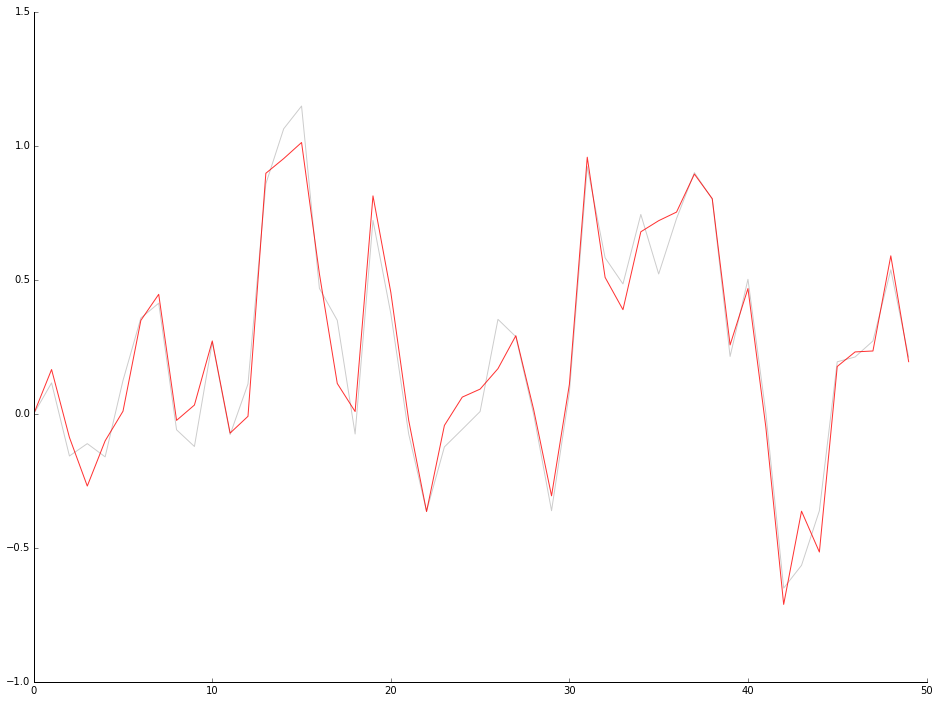

In [78]:

from numpy import dot, sum, tile, linalg
from numpy.linalg import inv, pinv
# from numpy.linalg import det
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(4) # make it reproducible
nsim = 50


X = [0]
Y = [0]
mu_0 = 0.1
phi = 0.5
x = 0 # x_0 = 0 
sigma_sq = 0.1
tau_sq =  0.01

for i in xrange(1,nsim):
    x = mu_0 + x*phi + np.random.normal(0.0, scale=np.sqrt(sigma_sq))
    y = x + np.random.normal(0.0, scale=np.sqrt(tau_sq))
    X.append(x)
    Y.append(y)


X = np.array(X)
Y = np.array(Y)
plt.figure(figsize=(16, 12))
plt.plot(xrange(0,nsim),X, alpha=.2, color='k')
plt.plot(xrange(0,nsim),Y, alpha=0.8, color='r')

remove_border()
# pinv(outer(X, Y, out=None))


At a given moment $t-1$ we can formulate a prediction about the next, still unobserved, moment $t$ according to our assume model. The position of the state $X_t$ given the observation in hand $1:t-1$ is expressed as a distribution $p(X_t | Y_{1:t-1})$. Because the noise is assumed Gaussian, the distribution for the predicted state is also Gaussian. Note that because of the Markovian property, the prediction based on $Y_{1:t-1}$ is the same as the one based just on $Y_{t-1}$. Specifically we have that 
$$ p(X_t | Y_{1:t-1}) = N(\mu_{t|t-1}, \Sigma_{t|t-1}) $$ 
$$\mu_{t|t-1} = \mu_0 + \phi \mu_{t-1} $$
$$ \Sigma_{t|t-1} = \Sigma_{t-1} + \sigma_t^2 $$  

Note that the above formulas does not directly include any observation values. That's because the information is already encoded in the $\mu_{t-1},\Sigma_{t-1}$ values.  


Once the observation $Y_t$ for time $t$ has been made we need to update our values. We calculate the updated $\mu_t, \Sigma_t$ as follows:
$$ p(X_t | Y_{1:t}) = N(X_t|\mu_t, \Sigma_{t}) $$ 

$$ \mu_t = \mu_{t|t-1} + K_t r_t $$
$$ \Sigma_t = (I-K_t C_t)\Sigma_{t|t-1}$$
where 
$$ r_t = y_t - \hat{y}_t,  \hat{y}_t = E[Y_t|Y_{1:t-1}] = \mu_{t|t-1}$$ 
and $K_t$ is the Kalman gain matrix, given by 
$$ K_t = \Sigma_{t|t-1} S_t^{-1}, S_t = \Sigma_{t|t-1} + \tau^2 $$

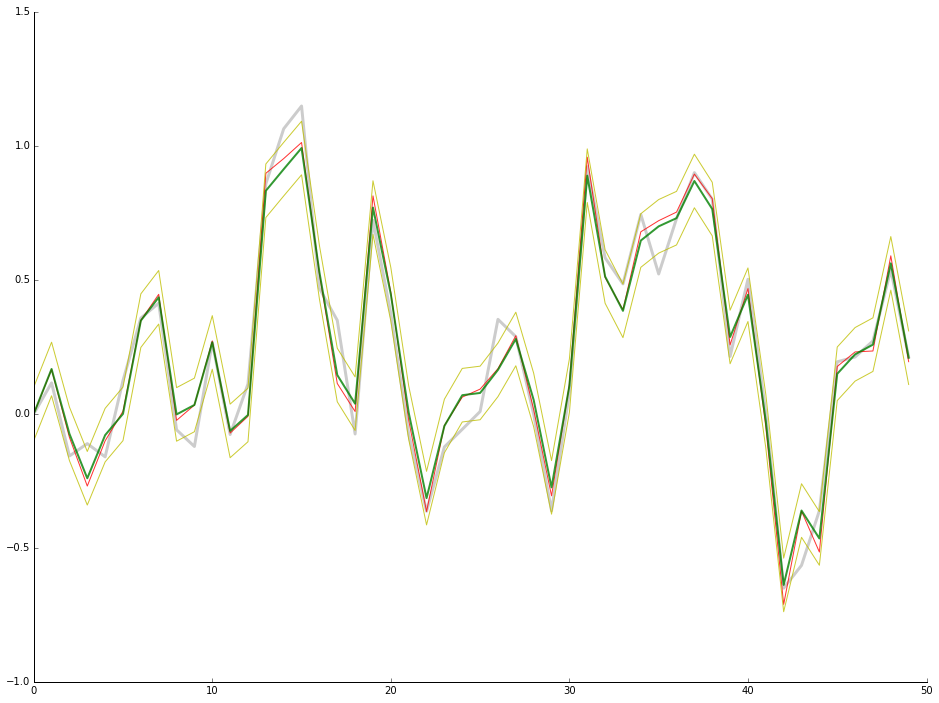

In [80]:
preds = [0]
msrs=[0]
sigma_t_1 = 0
mu_t_1 = 0

for i in xrange(1,nsim):
##  prediction step for the next moment - where I thought it would go next
    mu_t_t_1 = mu_0 + phi*mu_t_1 
    sigma_t_t_1 = sigma_t_1 + sigma_sq
    pred = np.random.normal(mu_t_t_1, scale=sigma_t_t_1)
    preds.append(mu_t_t_1) # the prediction should probably be equal to the mean value 

##  measurement step - where I thought it actually was after I got the observation
    r_t = Y[i] -  mu_t_t_1
    K_t = sigma_t_t_1 /(sigma_t_t_1 + tau_sq)
    mu_t = mu_t_t_1 + K_t *r_t
    sigma_t = (1-K_t)*sigma_t_t_1     
    msr = np.random.normal(mu_t, scale=sigma_t)
    msrs.append(msr)
    
##  update the variables for the next step    
    mu_t_1 = mu_t
    sigma_t_1 = sigma_t
    

preds = np.array(preds)
msrs = np.array(msrs)
plt.figure(figsize=(16, 12))
plt.plot(xrange(0,nsim),X, alpha=.2, color='k', lw=3)
plt.plot(xrange(0,nsim),Y, alpha=0.8, color='r', lw=1)
#plt.plot(xrange(0,nsim),preds, alpha=0.8, color='b')
plt.plot(xrange(0,nsim),msrs - np.sqrt(tau_sq), alpha=0.8, color='y')
plt.plot(xrange(0,nsim),msrs + np.sqrt(tau_sq), alpha=0.8, color='y')
plt.plot(xrange(0,nsim),msrs, lw = 2, alpha=0.8, color='g')

remove_border()
# pinv(outer(X, Y, out=None))